# Consistency analysis on PPMI results

## Demographics



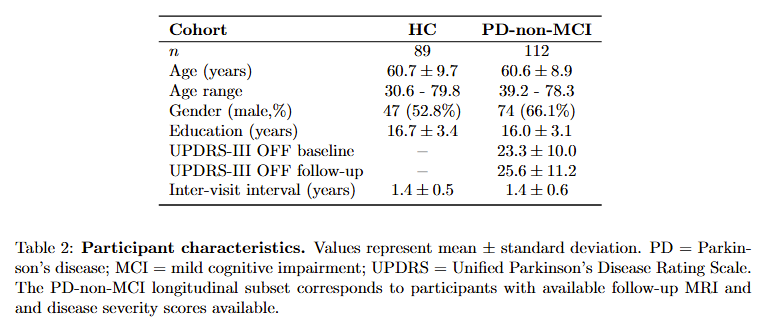

## Consistency

In [338]:
import pandas as pd
from pathlib import Path

anonymizer = False

root_dir = Path.cwd().parent.parent.parent.parent


def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
assert npv_dir.exists(), f"NPV dir does not exist: {anondir(npv_dir)}"
print(f"Using NPV dir: {anondir(npv_dir)}")
data_dir = root_dir / "notebooks" / "papers_data" / "parkinson" / "Current"
print(f"Using data dir: {anondir(data_dir)}")
assert data_dir.exists(), f"Data dir does not exist: {anondir(data_dir)}"

Running in root dir: /home/yohan/Work/livingpark-numerical-variability/freesurfer-fuzzy
Using NPV dir: /home/yohan/Work/livingpark-numerical-variability/freesurfer-fuzzy/npv/csv_all
Using data dir: /home/yohan/Work/livingpark-numerical-variability/freesurfer-fuzzy/notebooks/papers_data/parkinson/Current


### Load NPV maps

In [339]:
npv_thickness = pd.read_csv(npv_dir / "npv_hc-pd_baseline_thickness.csv")
npv_thickness_pd = pd.read_csv(npv_dir / "npv_pd_baseline_thickness.csv")
npv_thickness_long = pd.read_csv(npv_dir / "npv_hc-pd_thickness_longitudinal.csv")

npv_area = pd.read_csv(npv_dir / "npv_hc-pd_baseline_area.csv")
npv_area_pd = pd.read_csv(npv_dir / "npv_pd_baseline_area.csv")
npv_area_long = pd.read_csv(npv_dir / "npv_hc-pd_area_longitudinal.csv")

npv_volume = pd.read_csv(npv_dir / "npv_hc-pd_baseline_volume.csv")
npv_volume_pd = pd.read_csv(npv_dir / "npv_pd_baseline_volume.csv")
npv_volume_long = pd.read_csv(npv_dir / "npv_hc-pd_volume_longitudinal.csv")


npv_subcortical_volume = pd.read_csv(
    npv_dir / "npv_hc-pd_baseline_subcortical_volume.csv"
)
npv_subcortical_volume_pd = pd.read_csv(
    npv_dir / "npv_pd_baseline_subcortical_volume.csv"
)
npv_subcortical_volume_long = pd.read_csv(
    npv_dir / "npv_hc-pd_subcortical_volume_longitudinal.csv"
)

### Formula

In [340]:
import numpy as np
import scipy.stats


# ANCOVA
def std_F(F, npv):
    return 2 * np.sqrt(F) * npv


def std_p_F(F, df, npv):
    return 2 * np.sqrt(F) * scipy.stats.f.pdf(F, dfn=1, dfd=df) * npv


# T-test
def std_t(npv):
    return npv


def std_p_t(t, df, npv):
    return 2 * scipy.stats.t.pdf(np.abs(t), df) * npv


# Partial correlation
def std_r(r, n, npv):
    return np.sqrt((1 - r**2) ** 3 / (n - 1)) * npv


def std_p_r(r, n, npv):
    t = r * np.sqrt((n - 2) / (1 - r**2))
    return 2 * scipy.stats.t.pdf(np.abs(t), n - 2) * np.sqrt(((n - 2) / (n - 1))) * npv

In [341]:
import pandas as pd
from scipy.stats import beta
import numpy as np


def beta_params_from_mean_var(mu, var, eps=1e-12):
    """Return (a,b) for Beta by moment matching. Clamps var to < mu(1-mu)."""
    max_var = mu * (1 - mu) - eps
    # Clamp var for non-degenerate cases
    var_clamped = np.minimum(var, max_var)

    # Calculate k for non-degenerate cases
    # Ensure we don't divide by zero if var_clamped becomes zero due to clamping
    # This can happen if mu*(1-mu) is very small and var is also very small but positive.
    # The original code implicitly handles this by setting k=1e6 when var<=0.
    # Here, we ensure that if var_clamped is effectively zero, k is large.
    # A small positive value for the denominator to avoid division by zero for k calculation
    denominator = np.where(var_clamped == 0, eps, var_clamped)
    k_calculated = mu * (1 - mu) / denominator - 1.0
    # Ensure k is not negative, as it should be > 0 for Beta distribution
    k_calculated = np.maximum(k_calculated, eps)  # k must be > 0

    a_calculated = mu * k_calculated
    b_calculated = (1 - mu) * k_calculated

    return a_calculated, b_calculated


def flip_proba_beta(p0, sigma_P, alpha=0.05):
    """
    Flip probability at alpha with P ~ Beta(a,b).
    Provide either sigma_P.
    Works with pandas Series/DataFrames.
    """
    var_P = sigma_P**2
    a, b = beta_params_from_mean_var(p0, var_P)

    # Determine the flip probability based on p0 relative to alpha
    # Use np.where for vectorized conditional logic
    # pflip_non_significant = 1.0 - beta.cdf(alpha, a, b) # if p0 < alpha, flip if P > alpha
    pflip_significant = beta.cdf(alpha, a, b)  # if p0 >= alpha, flip if P <= alpha

    # pflip = np.where(p0 < alpha, pflip_significant, pflip_non_significant)
    pflip = pflip_significant

    # Clip the result to ensure it's within [0, 1]
    return np.clip(pflip, 0.0, 1.0)

In [342]:
from matplotlib import legend, markers
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


def plot_dumbbell(results, title, group=None):
    columns = [
        "region",
        "p_value",
        "npv",
        "std_p",
        "std_p_low",
        "std_p_high",
        "proba_significant",
    ] + ([] if group is None else [group])
    df = results.copy()
    df = df[columns]
    df.rename(
        columns={
            "std_p": "std_p",
            "std_r": "std_r",
            "sig": "sig",
            "p": "p_value",
            "std_p_low": "std_p_low",
            "std_p_high": "std_p_high",
            "proba_significant": "psig",
        },
        inplace=True,
    )
    df["std_p_low"] = df["std_p"] - df["std_p_low"]
    df["std_p_high"] = df["std_p_high"] - df["std_p"]

    col_label = "std_p"

    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["p-value", "std p-value", "Probability significance"],
    )

    fig_1 = px.scatter(df, x="region", y="p_value", color=group)
    # Add lines for each dumbbell
    fig_2 = px.scatter(
        df,
        x="region",
        y="std_p",
        color=group,
        error_y="std_p_low",
        error_y_minus="std_p_high",
        labels="std_p",
    )
    fig_3 = px.scatter(
        df,
        x="region",
        y="psig",
        color=group,
        labels="Flip probability",
    )

    fig.add_traces(fig_1.data, rows=1, cols=1)
    fig.add_traces(fig_2.data, rows=1, cols=2)
    fig.add_traces(fig_3.data, rows=1, cols=3)

    fig.update_layout(
        title=title,
        yaxis_title=col_label,
        xaxis_title="Value",
        hovermode="closest",
        height=600,
        width=1400,
    )

    fig.add_hline(y=0.05, line_color="red", line_width=2, row=1, col=1)
    fig.update_yaxes(range=[-0.05, 1.05])

    return fig

### Group differences at baseline

#### Cortical surface area

In [343]:
metric= "area"
npv = npv_area
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / f"ancova_baseline_{metric}.parquet")
ancova = ancova[~ancova.F.isna()]
ancova["n"] = ancova["n"].astype(int)
ancova = ancova.rename(columns={"n": "sample_size", "p-val": "p_value"})
ancova['significant'] = ancova['p_value'] < 0.05
ancova = ancova.groupby(by=["region", "hemisphere"]).agg(
    F_mean=("F", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
ancova = pd.merge(ancova, npv, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]

# Simulated from NPV
ancova["std_p"] = std_p_F(ancova["F_mean"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_low"]
)
ancova["std_p_high"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_high"]
)
ancova["proba_significant"] = flip_proba_beta(ancova["p_value_mean"], ancova["std_p"])

ancova.rename(columns={"p_value_mean": "p_value"}, inplace=True)
ancova["group"] = "simulated"

# sampled from raw data
ancova_est = ancova.copy()
ancova_est["group"] = "sampled"
ancova_est["std_p"] = ancova_est["p_value_std"]
ancova_est["proba_significant"] = flip_proba_beta(
    ancova_est["p_value"], ancova_est["std_p"]
)

ancova = pd.concat([ancova, ancova_est], ignore_index=True)
ancova["metric"] = f"cortical {metric}"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "cross-sectional"
ancova["timepoint"] = "baseline"
ancova['significant'] = ancova['p_value'] < 0.05

ancova_baseline_area = ancova.copy()

In [344]:
plot_dumbbell(
    ancova_baseline_area,
    "Group differences between PD and HC at baseline (cortical area)",
    "group"
)

#### Cortical thickness

In [345]:
metric= "thickness"
npv = npv_thickness
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / f"ancova_baseline_{metric}.parquet")
ancova = ancova[~ancova.F.isna()]

ancova["n"] = ancova["n"].astype(int)
ancova = ancova.rename(columns={"n": "sample_size", "p-val": "p_value"})
ancova['significant'] = ancova['p_value'] < 0.05
ancova = ancova.groupby(by=["region", "hemisphere"]).agg(
    F_mean=("F", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
ancova = pd.merge(ancova, npv, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]

# Simulated from NPV
ancova["std_p"] = std_p_F(ancova["F_mean"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_low"]
)
ancova["std_p_high"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_high"]
)
ancova["proba_significant"] = flip_proba_beta(ancova["p_value_mean"], ancova["std_p"])

ancova.rename(columns={"p_value_mean": "p_value"}, inplace=True)
ancova["group"] = "simulated"

# sampled from raw data
ancova_est = ancova.copy()
ancova_est["group"] = "sampled"
ancova_est["std_p"] = ancova_est["p_value_std"]
ancova_est["proba_significant"] = flip_proba_beta(
    ancova_est["p_value"], ancova_est["std_p"]
)

ancova = pd.concat([ancova, ancova_est], ignore_index=True)
ancova["metric"] = f"cortical {metric}"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "cross-sectional"
ancova["timepoint"] = "baseline"
ancova['significant'] = ancova['p_value'] < 0.05


ancova_baseline_thickness = ancova.copy()

In [346]:
plot_dumbbell(
    ancova_baseline_thickness,
    "Group differences between PD and HC at baseline (cortical thickness)",
    "group"
)

#### Cortical volume

In [347]:
metric= "volume"
npv = npv_volume
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / f"ancova_baseline_{metric}.parquet")
ancova = ancova[~ancova.F.isna()]

ancova["n"] = ancova["n"].astype(int)
ancova = ancova.rename(columns={"n": "sample_size", "p-val": "p_value"})
ancova['significant'] = ancova['p_value'] < 0.05
ancova = ancova.groupby(by=["region", "hemisphere"]).agg(
    F_mean=("F", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
ancova = pd.merge(ancova, npv, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]

# Simulated from NPV
ancova["std_p"] = std_p_F(ancova["F_mean"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_low"]
)
ancova["std_p_high"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_high"]
)
ancova["proba_significant"] = flip_proba_beta(ancova["p_value_mean"], ancova["std_p"])

ancova.rename(columns={"p_value_mean": "p_value"}, inplace=True)
ancova["group"] = "simulated"

# sampled from raw data
ancova_est = ancova.copy()
ancova_est["group"] = "sampled"
ancova_est["std_p"] = ancova_est["p_value_std"]
ancova_est["proba_significant"] = flip_proba_beta(
    ancova_est["p_value"], ancova_est["std_p"]
)

ancova = pd.concat([ancova, ancova_est], ignore_index=True)
ancova["metric"] = f"cortical {metric}"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "cross-sectional"
ancova["timepoint"] = "baseline"
ancova['significant'] = ancova['p_value'] < 0.05

ancova_baseline_volume = ancova.copy()

In [348]:
plot_dumbbell(
    ancova_baseline_volume,
    "Group differences between PD and HC at baseline (cortical volume)",
    "group"
)

#### Subcortical volumes

In [349]:
metric= "subcortical_volume"
npv = npv_subcortical_volume
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / f"ancova_baseline_{metric}.parquet")
ancova = ancova[~ancova.F.isna()]

ancova["n"] = ancova["n"].astype(int)
ancova = ancova.rename(columns={"n": "sample_size", "p-val": "p_value"})
ancova['significant'] = ancova['p_value'] < 0.05
ancova = ancova.groupby(by=["region"]).agg(
    F_mean=("F", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
ancova = pd.merge(ancova, npv, on=["region"])

# Simulated from NPV
ancova["std_p"] = std_p_F(ancova["F_mean"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_low"]
)
ancova["std_p_high"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_high"]
)
ancova["proba_significant"] = flip_proba_beta(ancova["p_value_mean"], ancova["std_p"])

ancova.rename(columns={"p_value_mean": "p_value"}, inplace=True)
ancova["group"] = "simulated"

# sampled from raw data
ancova_est = ancova.copy()
ancova_est["group"] = "sampled"
ancova_est["std_p"] = ancova_est["p_value_std"]
ancova_est["proba_significant"] = flip_proba_beta(
    ancova_est["p_value"], ancova_est["std_p"]
)

ancova = pd.concat([ancova, ancova_est], ignore_index=True)
ancova["metric"] = "subcortical volume"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "cross-sectional"
ancova["timepoint"] = "baseline"
ancova['significant'] = ancova['p_value'] < 0.05


ancova_baseline_subcortical_volume = ancova.copy()

In [350]:
plot_dumbbell(
    ancova_baseline_subcortical_volume,
    "Group differences between PD and HC at baseline (subcortical volume)",
    "group"
)

### Group differences longitudinally

#### Cortical surface area

In [351]:
metric= "area"
npv = npv_area_long
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / f"ancova_longitudinal_{metric}.parquet")
ancova = ancova[~ancova.F.isna()]
ancova["n"] = ancova["n"].astype(int)
ancova = ancova.rename(columns={"n": "sample_size", "p-val": "p_value"})
ancova['significant'] = ancova['p_value'] < 0.05
ancova = ancova.groupby(by=["region", "hemisphere"]).agg(
    F_mean=("F", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
ancova = pd.merge(ancova, npv, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]

# Simulated from NPV
ancova["std_p"] = std_p_F(ancova["F_mean"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_low"]
)
ancova["std_p_high"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_high"]
)
ancova["proba_significant"] = flip_proba_beta(ancova["p_value_mean"], ancova["std_p"])

ancova.rename(columns={"p_value_mean": "p_value"}, inplace=True)
ancova["group"] = "simulated"

# sampled from raw data
ancova_est = ancova.copy()
ancova_est["group"] = "sampled"
ancova_est["std_p"] = ancova_est["p_value_std"]
ancova_est["proba_significant"] = flip_proba_beta(
    ancova_est["p_value"], ancova_est["std_p"]
)

ancova = pd.concat([ancova, ancova_est], ignore_index=True)
ancova["metric"] = f"cortical {metric}"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "longitudinal"
ancova["timepoint"] = "baseline+follow-up"
ancova['significant'] = ancova['p_value'] < 0.05
ancova_longitudinal_area = ancova.copy()

In [352]:
plot_dumbbell(
    ancova_longitudinal_area,
    "Group differences between Parkinson's and controls longitudinally (cortical area)",
    "group"
)

#### Cortical thickness

In [353]:
metric= "thickness"
npv = npv_thickness_long
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / f"ancova_longitudinal_{metric}.parquet")
ancova = ancova[~ancova.F.isna()]

ancova["n"] = ancova["n"].astype(int)
ancova = ancova.rename(columns={"n": "sample_size", "p-val": "p_value"})
ancova['significant'] = ancova['p_value'] < 0.05
ancova = ancova.groupby(by=["region", "hemisphere"]).agg(
    F_mean=("F", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
ancova = pd.merge(ancova, npv, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]

# Simulated from NPV
ancova["std_p"] = std_p_F(ancova["F_mean"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_low"]
)
ancova["std_p_high"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_high"]
)
ancova["proba_significant"] = flip_proba_beta(ancova["p_value_mean"], ancova["std_p"])

ancova.rename(columns={"p_value_mean": "p_value"}, inplace=True)
ancova["group"] = "simulated"

# sampled from raw data
ancova_est = ancova.copy()
ancova_est["group"] = "sampled"
ancova_est["std_p"] = ancova_est["p_value_std"]
ancova_est["proba_significant"] = flip_proba_beta(
    ancova_est["p_value"], ancova_est["std_p"]
)

ancova = pd.concat([ancova, ancova_est], ignore_index=True)
ancova["metric"] = f"cortical {metric}"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "longitudinal"
ancova["timepoint"] = "baseline+follow-up"
ancova['significant'] = ancova['p_value'] < 0.05

ancova_longitudinal_thickness = ancova.copy()

In [354]:
plot_dumbbell(
    ancova_longitudinal_thickness,
    "Group differences between Parkinson's and controls longitudinally (cortical thickness)",
    "group"
)

#### Cortical volume

In [355]:
metric= "volume"
npv = npv_volume_long
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / f"ancova_longitudinal_{metric}.parquet")
ancova = ancova[~ancova.F.isna()]

ancova["n"] = ancova["n"].astype(int)
ancova = ancova.rename(columns={"n": "sample_size", "p-val": "p_value"})
ancova['significant'] = ancova['p_value'] < 0.05
ancova = ancova.groupby(by=["region", "hemisphere"]).agg(
    F_mean=("F", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
ancova = pd.merge(ancova, npv, on=["region", "hemisphere"])
ancova["region"] = ancova["hemisphere"] + "-" + ancova["region"]

# Simulated from NPV
ancova["std_p"] = std_p_F(ancova["F_mean"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_low"]
)
ancova["std_p_high"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_high"]
)
ancova["proba_significant"] = flip_proba_beta(ancova["p_value_mean"], ancova["std_p"])

ancova.rename(columns={"p_value_mean": "p_value"}, inplace=True)
ancova["group"] = "simulated"

# sampled from raw data
ancova_est = ancova.copy()
ancova_est["group"] = "sampled"
ancova_est["std_p"] = ancova_est["p_value_std"]
ancova_est["proba_significant"] = flip_proba_beta(
    ancova_est["p_value"], ancova_est["std_p"]
)

ancova = pd.concat([ancova, ancova_est], ignore_index=True)
ancova["metric"] = f"cortical {metric}"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "longitudinal"
ancova["timepoint"] = "baseline+follow-up"
ancova['significant'] = ancova['p_value'] < 0.05

ancova_longitudinal_volume = ancova.copy()

In [356]:
plot_dumbbell(
    ancova_longitudinal_volume,
    "Group differences between Parkinson's and controls longitudinally (cortical volume)",
    "group"
)

#### Subcortical volumes

In [357]:
metric= "subcortical_volume"
npv = npv_subcortical_volume_long
parquet_dir = root_dir / "data"
ancova = pd.read_parquet(parquet_dir / "ancova" / f"ancova_longitudinal_{metric}.parquet")
ancova = ancova[~ancova.F.isna()]

ancova["n"] = ancova["n"].astype(int)
ancova = ancova.rename(columns={"n": "sample_size", "p-val": "p_value"})
ancova['significant'] = ancova['p_value'] < 0.05
ancova = ancova.groupby(by=["region"]).agg(
    F_mean=("F", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
ancova = pd.merge(ancova, npv, on=["region"])

# Simulated from NPV
ancova["std_p"] = std_p_F(ancova["F_mean"], ancova["sample_size"], ancova["npv"])
ancova["std_p_low"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_low"]
)
ancova["std_p_high"] = std_p_F(
    ancova["F_mean"], ancova["sample_size"], ancova["npv_CI_high"]
)
ancova["proba_significant"] = flip_proba_beta(ancova["p_value_mean"], ancova["std_p"])

ancova.rename(columns={"p_value_mean": "p_value"}, inplace=True)
ancova["group"] = "simulated"

# sampled from raw data
ancova_est = ancova.copy()
ancova_est["group"] = "sampled"
ancova_est["std_p"] = ancova_est["p_value_std"]
ancova_est["proba_significant"] = flip_proba_beta(
    ancova_est["p_value"], ancova_est["std_p"]
)

ancova = pd.concat([ancova, ancova_est], ignore_index=True)
ancova["metric"] = "subcortical volume"
ancova["test"] = "F"
ancova["analysis"] = "Group differences"
ancova["study"] = "longitudinal"
ancova["timepoint"] = "baseline+follow-up"
ancova['significant'] = ancova['p_value'] < 0.05

ancova_longitudinal_subcortical_volume = ancova.copy()

In [358]:
plot_dumbbell(
    ancova_longitudinal_subcortical_volume,
    "Group differences between PD and HC at baseline longitudinally (subcortical volume)",
    "group"
)

### Partial correlation at baseline

#### Cortical surface area

In [359]:
metric= "area"
npv = npv_area
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(parquet_dir / "partial_correlation" / f"partial_correlation_baseline_{metric}.parquet")
pcorr = pcorr[~pcorr.r.isna()]

pcorr["n"] = pcorr["n"].astype(int)
pcorr = pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"})
pcorr['significant'] = pcorr['p_value'] < 0.05
pcorr = pcorr.groupby(by=["region", "hemisphere"]).agg(
    r_mean=("r", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
pcorr = pd.merge(pcorr, npv, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]

# Simulated from NPV
pcorr["std_p"] = std_p_r(pcorr["r_mean"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_low"]
)
pcorr["std_p_high"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_high"]
)
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value_mean"], pcorr["std_p"])

pcorr.rename(columns={"p_value_mean": "p_value"}, inplace=True)
pcorr["group"] = "simulated"

# sampled from raw data
pcorr_est = pcorr.copy()
pcorr_est["group"] = "sampled"
pcorr_est["std_p"] = pcorr_est["p_value_std"]
pcorr_est["proba_significant"] = flip_proba_beta(
    pcorr_est["p_value"], pcorr_est["std_p"]
)

pcorr = pd.concat([pcorr, pcorr_est], ignore_index=True)
pcorr["metric"] = f"cortical {metric}"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "cross-sectional"
pcorr["timepoint"] = "baseline"
pcorr['significant'] = pcorr['p_value'] < 0.05

pcorr_baseline_area = pcorr.copy()

In [360]:
plot_dumbbell(pcorr_baseline_area, "Partial correlation at baseline (area)", "group")

#### Cortical thickness

In [361]:
metric= "thickness"
npv = npv_thickness
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(parquet_dir / "partial_correlation" / f"partial_correlation_baseline_{metric}.parquet")
pcorr = pcorr[~pcorr.r.isna()]

pcorr["n"] = pcorr["n"].astype(int)
pcorr = pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"})
pcorr['significant'] = pcorr['p_value'] < 0.05
pcorr = pcorr.groupby(by=["region", "hemisphere"]).agg(
    r_mean=("r", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
pcorr = pd.merge(pcorr, npv, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]

# Simulated from NPV
pcorr["std_p"] = std_p_r(pcorr["r_mean"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_low"]
)
pcorr["std_p_high"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_high"]
)
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value_mean"], pcorr["std_p"])

pcorr.rename(columns={"p_value_mean": "p_value"}, inplace=True)
pcorr["group"] = "simulated"

# sampled from raw data
pcorr_est = pcorr.copy()
pcorr_est["group"] = "sampled"
pcorr_est["std_p"] = pcorr_est["p_value_std"]
pcorr_est["proba_significant"] = flip_proba_beta(
    pcorr_est["p_value"], pcorr_est["std_p"]
)

pcorr = pd.concat([pcorr, pcorr_est], ignore_index=True)
pcorr["metric"] = f"cortical {metric}"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "cross-sectional"
pcorr["timepoint"] = "baseline"
pcorr['significant'] = pcorr['p_value'] < 0.05

pcorr_baseline_thickness = pcorr.copy()

In [362]:
plot_dumbbell(pcorr_baseline_thickness, "Partial correlation at baseline (thickness)", "group")

#### Cortical volume

In [363]:
metric= "volume"
npv = npv_volume
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(parquet_dir / "partial_correlation" / f"partial_correlation_baseline_{metric}.parquet")
pcorr = pcorr[~pcorr.r.isna()]

pcorr["n"] = pcorr["n"].astype(int)
pcorr = pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"})
pcorr['significant'] = pcorr['p_value'] < 0.05
pcorr = pcorr.groupby(by=["region", "hemisphere"]).agg(
    r_mean=("r", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
pcorr = pd.merge(pcorr, npv, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]

# Simulated from NPV
pcorr["std_p"] = std_p_r(pcorr["r_mean"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_low"]
)
pcorr["std_p_high"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_high"]
)
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value_mean"], pcorr["std_p"])

pcorr.rename(columns={"p_value_mean": "p_value"}, inplace=True)
pcorr["group"] = "simulated"

# sampled from raw data
pcorr_est = pcorr.copy()
pcorr_est["group"] = "sampled"
pcorr_est["std_p"] = pcorr_est["p_value_std"]
pcorr_est["proba_significant"] = flip_proba_beta(
    pcorr_est["p_value"], pcorr_est["std_p"]
)

pcorr = pd.concat([pcorr, pcorr_est], ignore_index=True)
pcorr["metric"] = f"cortical {metric}"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "cross-sectional"
pcorr["timepoint"] = "baseline"
pcorr['significant'] = pcorr['p_value'] < 0.05

pcorr_baseline_volume = pcorr.copy()

In [364]:
plot_dumbbell(pcorr_baseline_volume, "Partial correlation at baseline (volume)", "group")

#### Subcortical volume

In [365]:
metric= "subcortical_volume"
npv = npv_subcortical_volume
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(parquet_dir / "partial_correlation" / f"partial_correlation_baseline_{metric}.parquet")
pcorr = pcorr[~pcorr.r.isna()]

pcorr["n"] = pcorr["n"].astype(int)
pcorr = pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"})
pcorr['significant'] = pcorr['p_value'] < 0.05
pcorr = pcorr.groupby(by=["region"]).agg(
    r_mean=("r", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
)
pcorr = pd.merge(pcorr, npv, on=["region"])

# Simulated from NPV
pcorr["std_p"] = std_p_r(pcorr["r_mean"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_low"]
)
pcorr["std_p_high"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_high"]
)
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value_mean"], pcorr["std_p"])

pcorr.rename(columns={"p_value_mean": "p_value"}, inplace=True)
pcorr["group"] = "simulated"

# Sampled from raw data
pcorr_est = pcorr.copy()
pcorr_est["group"] = "sampled"
pcorr_est["std_p"] = pcorr_est["p_value_std"]
pcorr_est["proba_significant"] = flip_proba_beta(
    pcorr_est["p_value"], pcorr_est["std_p"]
)

pcorr = pd.concat([pcorr, pcorr_est], ignore_index=True)
pcorr["metric"] = "subcortical volume"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "cross-sectional"
pcorr["timepoint"] = "baseline"

pcorr_baseline_subcortical_volume = pcorr.copy()

In [366]:
plot_dumbbell(
    pcorr_baseline_subcortical_volume,
    "Partial correlation at baseline (subcortical volume)",
    "group"
)

### Partial correlation longitudinally

#### Cortical surface area

In [367]:
metric= "area"
npv = npv_area_long
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(parquet_dir / "partial_correlation" / f"partial_correlation_longitudinal_{metric}.parquet")
pcorr = pcorr[~pcorr.r.isna()]
pcorr["n"] = pcorr["n"].astype(int)
pcorr = pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"})
pcorr['significant'] = pcorr['p_value'] < 0.05
pcorr = pcorr.groupby(by=["region", "hemisphere"]).agg(
    r_mean=("r", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
    )
pcorr = pd.merge(pcorr, npv, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]

# Simulated from NPV
pcorr["std_p"] = std_p_r(pcorr["r_mean"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_low"]
)
pcorr["std_p_high"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_high"]
)
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value_mean"], pcorr["std_p"])

pcorr.rename(columns={"p_value_mean": "p_value"}, inplace=True)
pcorr["group"] = "simulated"

# Estimated from raw data
pcorr_est = pcorr.copy()
pcorr_est["group"] = "sampled"
pcorr_est["std_p"] = pcorr_est["p_value_std"]
pcorr_est["proba_significant"] = flip_proba_beta(
    pcorr_est["p_value"], pcorr_est["std_p"]
)

pcorr = pd.concat([pcorr, pcorr_est], ignore_index=True)
pcorr["metric"] = f"cortical {metric}"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "longitudinal"
pcorr["timepoint"] = "baseline+follow-up"
pcorr['significant'] = pcorr['p_value'] < 0.05

pcorr_longitudinal_area = pcorr.copy()

In [368]:
plot_dumbbell(pcorr_longitudinal_area, "Partial correlation longitudinal (area)", "group")

#### Cortical thickness

In [369]:
metric= "thickness"
npv = npv_thickness_long
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(parquet_dir / "partial_correlation" / f"partial_correlation_longitudinal_{metric}.parquet")
pcorr = pcorr[~pcorr.r.isna()]
pcorr["n"] = pcorr["n"].astype(int)
pcorr = pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"})
pcorr['significant'] = pcorr['p_value'] < 0.05
pcorr = pcorr.groupby(by=["region", "hemisphere"]).agg(
    r_mean=("r", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
    )
pcorr = pd.merge(pcorr, npv, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]

# Simulated from NPV
pcorr["std_p"] = std_p_r(pcorr["r_mean"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_low"]
)
pcorr["std_p_high"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_high"]
)
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value_mean"], pcorr["std_p"])

pcorr.rename(columns={"p_value_mean": "p_value"}, inplace=True)
pcorr["group"] = "simulated"

# Estimated from raw data
pcorr_est = pcorr.copy()
pcorr_est["group"] = "sampled"
pcorr_est["std_p"] = pcorr_est["p_value_std"]
pcorr_est["proba_significant"] = flip_proba_beta(
    pcorr_est["p_value"], pcorr_est["std_p"]
)

pcorr = pd.concat([pcorr, pcorr_est], ignore_index=True)
pcorr["metric"] = f"cortical {metric}"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "longitudinal"
pcorr["timepoint"] = "baseline+follow-up"

pcorr['significant'] = pcorr['p_value'] < 0.05

pcorr_longitudinal_thickness = pcorr.copy()

In [370]:
plot_dumbbell(
    pcorr_longitudinal_thickness, "Partial correlation longitudinal (thickness)", "group"
)

#### Cortical volume

In [371]:
metric= "volume"
npv = npv_volume_long
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(parquet_dir / "partial_correlation" / f"partial_correlation_longitudinal_{metric}.parquet")
pcorr = pcorr[~pcorr.r.isna()]
pcorr["n"] = pcorr["n"].astype(int)
pcorr = pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"})
pcorr['significant'] = pcorr['p_value'] < 0.05
pcorr = pcorr.groupby(by=["region", "hemisphere"]).agg(
    r_mean=("r", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
    )
pcorr = pd.merge(pcorr, npv, on=["region", "hemisphere"])
pcorr["region"] = pcorr["hemisphere"] + "-" + pcorr["region"]

# Simulated from NPV
pcorr["std_p"] = std_p_r(pcorr["r_mean"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_low"]
)
pcorr["std_p_high"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_high"]
)
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value_mean"], pcorr["std_p"])

pcorr.rename(columns={"p_value_mean": "p_value"}, inplace=True)
pcorr["group"] = "simulated"

# Estimated from raw data
pcorr_est = pcorr.copy()
pcorr_est["group"] = "sampled"
pcorr_est["std_p"] = pcorr_est["p_value_std"]
pcorr_est["proba_significant"] = flip_proba_beta(
    pcorr_est["p_value"], pcorr_est["std_p"]
)

pcorr = pd.concat([pcorr, pcorr_est], ignore_index=True)
pcorr["metric"] = f"cortical {metric}"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "longitudinal"
pcorr["timepoint"] = "baseline+follow-up"

pcorr['significant'] = pcorr['p_value'] < 0.05

pcorr_longitudinal_volume = pcorr.copy()

In [372]:
plot_dumbbell(pcorr_longitudinal_volume, "Partial correlation longitudinal (thickness)", "group")

#### Subcortical volume

In [373]:
metric= "subcortical_volume"
npv = npv_subcortical_volume_long
parquet_dir = root_dir / "data"
pcorr = pd.read_parquet(parquet_dir / "partial_correlation" / f"partial_correlation_longitudinal_{metric}.parquet")
pcorr = pcorr[~pcorr.r.isna()]
pcorr["n"] = pcorr["n"].astype(int)
pcorr = pcorr.rename(columns={"n": "sample_size", "p-val": "p_value"})
pcorr['significant'] = pcorr['p_value'] < 0.05
pcorr = pcorr.groupby(by=["region"]).agg(
    r_mean=("r", "mean"),
    p_value_mean=("p_value", "mean"),
    p_value_std=("p_value", "std"),
    sample_size=("sample_size", "mean"),
    fraction_significant=("significant", "mean"),
    count_significant=("significant", "sum"),
    )
pcorr = pd.merge(pcorr, npv, on=["region"])

# Simulated from NPV
pcorr["std_p"] = std_p_r(pcorr["r_mean"], pcorr["sample_size"], pcorr["npv"])
pcorr["std_p_low"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_low"]
)
pcorr["std_p_high"] = std_p_r(
    pcorr["r_mean"], pcorr["sample_size"], pcorr["npv_CI_high"]
)
pcorr["proba_significant"] = flip_proba_beta(pcorr["p_value_mean"], pcorr["std_p"])

pcorr.rename(columns={"p_value_mean": "p_value"}, inplace=True)
pcorr["group"] = "simulated"

# sampled from raw data
pcorr_est = pcorr.copy()
pcorr_est["group"] = "sampled"
pcorr_est["std_p"] = pcorr_est["p_value_std"]
pcorr_est["proba_significant"] = flip_proba_beta(
    pcorr_est["p_value"], pcorr_est["std_p"]
)

pcorr = pd.concat([pcorr, pcorr_est], ignore_index=True)
pcorr["metric"] = "subcortical volume"
pcorr["test"] = "r"
pcorr["analysis"] = "partial correlation"
pcorr["study"] = "longitudinal"
pcorr["timepoint"] = "baseline+follow-up"
pcorr['significant'] = pcorr['p_value'] < 0.05

pcorr_longitudinal_subcortical_volume = pcorr.copy()

In [374]:
plot_dumbbell(
    pcorr_longitudinal_subcortical_volume,
    "Partial correlation longitudinal (subcortical volume)",
    "group"
)

In [375]:
df = pd.concat(
    [
        ancova_baseline_thickness,
        ancova_baseline_area,
        ancova_baseline_subcortical_volume,
        ancova_baseline_volume,
        pcorr_baseline_thickness,
        pcorr_baseline_area,
        pcorr_baseline_subcortical_volume,
        pcorr_baseline_volume,
        ancova_longitudinal_thickness,
        ancova_longitudinal_area,
        ancova_longitudinal_subcortical_volume,
        ancova_longitudinal_volume,
        pcorr_longitudinal_thickness,
        pcorr_longitudinal_area,
        pcorr_longitudinal_subcortical_volume,
        pcorr_longitudinal_volume,
    ],
    ignore_index=True,
)
assert "proba_significant" in df.columns
assert "significant" in df.columns
assert "sample_size" in df.columns
assert "test" in df.columns
assert "metric" in df.columns
df.to_csv(data_dir / "uncertainty_stats.csv", index=False)